In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import seaborn as sns
from scipy.stats import poisson
import statsmodels.api as sm
import statsmodels.formula.api as smf
import itertools
from IPython.display import display, HTML

## Chargement du dataset 

In [2]:
match = pd.read_csv('results.csv')

## Analyse et exploration des données

In [3]:
match.head()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
0,1872-11-30,Scotland,England,0,0,Friendly,Glasgow,Scotland,False
1,1873-03-08,England,Scotland,4,2,Friendly,London,England,False
2,1874-03-07,Scotland,England,2,1,Friendly,Glasgow,Scotland,False
3,1875-03-06,England,Scotland,2,2,Friendly,London,England,False
4,1876-03-04,Scotland,England,3,0,Friendly,Glasgow,Scotland,False


On s'apperçoit que chaque ligne est composée de :
    - La date de rencontre
    - Les deux équipes et leurs scores
    - Le tournoi
    - L'emplacement : pays et villes.
    - Si l'emplacement est neutre
    
Je souhaite d'abord définir le type de date sur datetime.

In [4]:
match = match.astype({'date':'datetime64[ns]'})

### Quels sont les tournois les plus joués ?

In [5]:
tournament = match['tournament'].value_counts()
tournament

Friendly                                17029
FIFA World Cup qualification             7236
UEFA Euro qualification                  2582
African Cup of Nations qualification     1672
FIFA World Cup                            900
                                        ...  
Dragon Cup                                  4
World Unity Cup                             4
Copa América qualification                  2
AFF Championship qualification              2
Atlantic Heritage Cup                       2
Name: tournament, Length: 112, dtype: int64

## Création d'un Dataframe

On se fixe comme objectif de créer un dataframe avec les statistiques par équipe comme la somme, le nombre et la moyenne du score pour chaque équipe.

In [6]:
#Création de deux dataframe pour les équipes à domicile et à l'extérieur
home = match[['home_team', 'home_score']].rename(columns={'home_team':'team', 'home_score':'score'})
away = match[['away_team', 'away_score']].rename(columns={'away_team':'team', 'away_score':'score'})
#Fusionner en un
team_score = home.append(away).reset_index(drop=True)
#On récupère pour chaque équipe la somme, le nombre et la moyenne du score (les buts)
country_info = team_score.groupby('team')['score'].agg(['sum','count','mean']).reset_index()
country_info = country_info.rename(columns={'sum':'nb_goals', 'count':'nb_matches', 'mean':'goal_avg'})

del home, away

In [7]:
country_info

,team,nb_goals,nb_matches,goal_avg
0,Abkhazia,48,28,1.714286
1,Afghanistan,114,111,1.027027
2,Albania,307,334,0.919162
3,Alderney,15,19,0.789474
4,Algeria,707,505,1.400000
...,...,...,...,...
307,Yugoslavia,940,480,1.958333
308,Zambia,1121,718,1.561281
309,Zanzibar,187,205,0.912195
310,Zimbabwe,625,456,1.370614


### Quelles sont les équipes qui ont joué le plus de matchs ?

Text(0.5, 1.0, 'TOP 10 DES MATCHS LES PLUS JOUES')

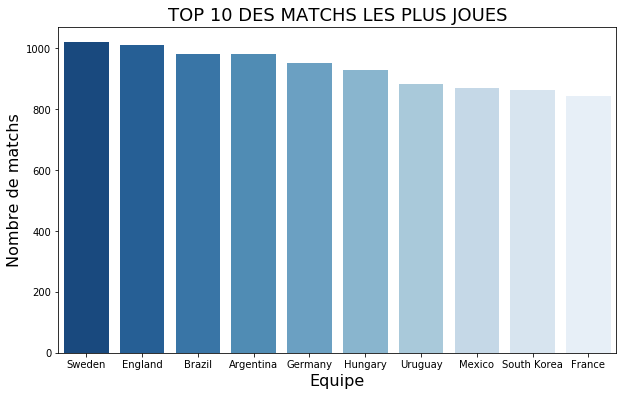

In [8]:
#On détermine la taille du graph
plt.figure(figsize = (10,6))

#On trie les informations de la colonnes nb_matches dans l'ordre croissant (on s'arrête aux dix premières équipes)
plt_data = country_info.sort_values(by='nb_matches', ascending=False)[:10]

#On affiche ces informations dans un diagramme à barre avec pour ordonné : l'équipe, et pour abscisse : nombre de matchs
ax = sns.barplot(x="team", y="nb_matches", data=plt_data, palette="Blues_r")

#On détermine les labels (titre) et la police du texte pour le graph
ax.set_xlabel('Equipe', size=16)
ax.set_ylabel('Nombre de matchs', size=16)
ax.set_title("TOP 10 DES MATCHS LES PLUS JOUES", fontsize=18)

### Quelles sont les équipes qui ont le plus marqué ?

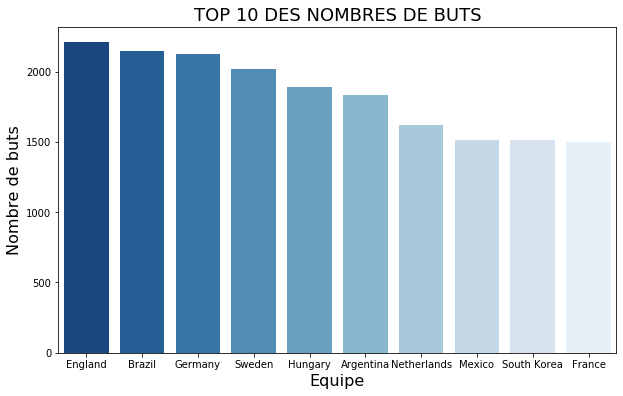

In [9]:
plt.figure(figsize = (10,6))
plt_data = country_info.sort_values(by='nb_goals', ascending=False)[:10]
ax = sns.barplot(x="team", y="nb_goals", data=plt_data, palette="Blues_r")
ax.set_xlabel('Equipe', size=16)
ax.set_ylabel('Nombre de buts', size=16)
ax.set_title("TOP 10 DES NOMBRES DE BUTS", fontsize=18)

del plt_data, country_info

### On calcule la moyenne des buts à domicile à l'extérieur

In [10]:
means = match[['home_score','away_score']].mean()
means

home_score    1.744813
away_score    1.187680
dtype: float64

On peut remarquer qu'en moyenne, l'équipe à domicile a marqué plus de buts que l'équipe à l'extérieur.

In [11]:
#Nous vérifions si nous retrouvons des valeurs manquantes 
match.isnull().values.any()

False

In [12]:
match.isnull().sum()

date          0
home_team     0
away_team     0
home_score    0
away_score    0
tournament    0
city          0
country       0
neutral       0
dtype: int64

#### Nous souhaitons maintenant savoir qu'elle la meilleure équipe du monde !  

Pour cela, nous allons créer un second Dataframe avec pour chaque équipe :
- Le nombre total de matchs joués
- Le nombre total de victoire
- Le pourcentage de victoire (total, à domicile et àl'extérieur)

A noter, j'ai exclus les équipes nationales qui ont joué moins de 100 matchs lorsque le calcul impliquait des ratios.


In [13]:
#On convertit la date pour qu'elle soit au bon format et on la définie comme index
date= pd.to_datetime(match.date.values)
match['date']=date
match.set_index('date', inplace=True)


#On récupère la colonne des résultats (victoires, égalités et défaites)
win= np.where(match.home_score > match.away_score, 'win', None)
tie=np.where(match.home_score == match.away_score, 'tie', None)
loss= np.where(match.home_score < match.away_score, 'loss', None)

results=pd.DataFrame([win, tie, loss]).T
results
x=[value[value != None]  for value in results.values]
#x=np.array(x)
#x=x.tolist()
match['result']= x
match['result']=np.squeeze(match.result.tolist())

#On récupère le nombre de but
match['goals']= match.home_score + match.away_score


#A domicile
home_teams=match.groupby(['home_team','result']).count()['city'].sort_values(ascending=False).reset_index().rename(columns={'city': 'count'})


home_matches=[]
for team in home_teams.home_team:
    tot_matches= home_teams[home_teams.home_team== team]['count'].sum()
    home_matches.append(tot_matches)
   
home_teams['home_matches']=home_matches
home_teams['pct_home_victory']= home_teams['count']/ home_teams['home_matches']


#A l'extérieur
away_teams=match.groupby(['away_team','result']).count()['city'].sort_values(ascending=False).reset_index().rename(columns={'city': 'count'})
away_teams.replace({'loss': 'win', 'win':'loss'}, inplace=True) #loss signifie la victoire pour l'équipe à l'extérieur

away_tot_matches=[]
for team in away_teams.away_team:
    tot_matches= away_teams[away_teams.away_team == team]['count'].sum()
    away_tot_matches.append(tot_matches)

away_teams['away_matches']= away_tot_matches
away_teams['pct_victory_away'] = away_teams['count']/away_teams['away_matches']


#On ajuste la terminologie et l'index
home_teams.rename(columns={'result': 'home_results', 'count': 'home_count'}, inplace=True)
home_teams.set_index('home_team', inplace=True)
away_teams.rename(columns={'result': 'away_results', 'count': 'away_count'}, inplace=True)
away_teams.set_index('away_team', inplace=True)


#On définit les gagnants et les perdants
home_winners= home_teams[home_teams.home_results=='win']
away_winners= away_teams[away_teams.away_results=='win']
home_losers= home_teams[home_teams.home_results=='loss']
away_losers= away_teams[away_teams.away_results=='loss']


#On fusionne l'ensemble des données
winners=pd.merge(home_winners, away_winners, left_index=True, right_index=True, how='inner')
losers=pd.merge(home_losers, away_losers, left_index=True, right_index=True, how='inner')
losers.rename(columns={'pct_home_victory': 'pct_home_defeats', 'pct_victory_away': 'pct_away_defeats'}, inplace=True)

winners['tot_count']= winners.home_count + winners.away_count
winners['tot_matches']= winners.home_matches + winners.away_matches
winners['tot_pct_victory']= winners.tot_count/winners.tot_matches
winners= winners[winners.tot_matches >= 100] #Uniquement les clubs qui ont joué au moins 100 matchs 
winners_pct= winners[['pct_home_victory', 'pct_victory_away', 'tot_pct_victory']]

losers['tot_count']= losers.home_count + losers.away_count
losers['tot_matches']= losers.home_matches + losers.away_matches
losers['tot_pct_defeats']= losers.tot_count/losers.tot_matches
losers= losers[losers.tot_matches >= 100] #Uniquement les clubs qui ont joué au moins 100 matchs 
losers_pct= losers[['pct_home_defeats', 'pct_away_defeats', 'tot_pct_defeats']]


#Pourcentage total
winners_pct.sort_values(by='tot_pct_victory', ascending=False)
winners_pct=np.round(winners_pct*100, 2)
winners_pct['tot_count']= winners.tot_count
winners_pct['tot_matches']= winners.tot_matches


losers_pct=np.round(losers_pct*100, 2)
losers_pct['tot_count']= losers.tot_count
losers_pct['tot_matches']= losers.tot_matches


winners_pct.sort_values(by='tot_pct_victory', ascending=False)


,pct_home_victory,pct_victory_away,tot_pct_victory,tot_count,tot_matches
Brazil,71.13,53.51,63.71,625,981
Spain,68.33,47.92,58.48,407,696
Germany,62.52,53.60,58.36,555,951
England,61.85,51.66,56.68,573,1011
Iran,63.21,43.38,54.51,272,499
...,...,...,...,...,...
Malta,15.91,6.70,11.78,47,399
Seychelles,21.57,3.23,11.50,13,113
Somalia,13.64,6.35,9.35,10,107
Luxembourg,11.21,5.52,8.66,35,404


On peut remarquer qu'avec 625 victoires sur 997 matchs, le Brésil est au-dessus de tous les autres équipes. D'un autre côté, le Liechtenstein avec 154 défaites en 194 matchs joués est la pire équipe nationale de football de l'histoire en termes de résultats.

## Prédictions 

In [67]:
home_matches=match.groupby('home_team').sum().rename(columns={'home_score': 'goals_scored_home', 'away_score' : 'goals_taken_home'})

away_matches=match.groupby('away_team').sum().rename(columns={'home_score': 'goals_taken_away', 'away_score' : 'goals_scored_away'})

score= pd.merge(home_matches, away_matches, how='inner', right_index= True, left_index=True)

score['tot_goals_scored']= score['goals_scored_home'] + score['goals_scored_away']
score['tot_goals_taken']= score['goals_taken_home'] + score['goals_taken_away']
score['diff_goals_tot'] = score['tot_goals_scored'] - score['tot_goals_taken']
score.drop(columns=['neutral_x', 'goals_x', 'neutral_y', 'goals_y'], inplace=True)

score=pd.merge(score, winners[['home_matches', 'away_matches', 'tot_matches']], how='inner', right_index=True, left_index=True)

score['home_goals_pct'] = score['goals_scored_home']/ score['home_matches']
score['away_goals_pct'] = score['goals_scored_away']/ score['away_matches']
score['home_goals_taken_pct'] = score['goals_taken_home']/ score['home_matches']
score['away_goals_taken_pct'] = score['goals_taken_away']/ score['away_matches']
score['tot_goals_scored_pct'] = score['tot_goals_scored']/ score['tot_matches']
score['tot_goals_taken_pct'] = score['tot_goals_taken']/ score['tot_matches']
score_pct= score[['home_goals_pct', 'away_goals_pct', 'home_goals_taken_pct', 'away_goals_taken_pct',
                 'tot_goals_scored_pct', 'tot_goals_taken_pct', 'diff_goals_tot']]

score_pct.sort_values(by='diff_goals_tot', ascending=False)

total_ratio= pd.merge(score_pct, winners_pct, how='inner', right_index=True, left_index=True)
total_ratio= pd.merge(total_ratio, losers_pct, how='inner', right_index=True, left_index=True)

score_pct.sort_values(by='diff_goals_tot', ascending=False)

correlation= total_ratio[['tot_goals_scored_pct', 'tot_goals_taken_pct', 
                          'tot_pct_victory','tot_pct_defeats']].corr()




### On veut prédire le taux de victoire / perte

In [68]:
total_ratio.corr()['tot_pct_victory'] #check correlation
train = np.array(total_ratio.iloc[:, :7])
test= np.array(total_ratio['tot_pct_victory'])

In [69]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train, test, random_state=42)

In [70]:
from sklearn.linear_model import LinearRegression
lr=LinearRegression()
lr.fit(X_train, y_train)
lr.score(X_train,y_train)

0.9354979001505713

In [71]:
lr.score(X_test, y_test)

0.9328461281788243

In [72]:
from sklearn.ensemble import RandomForestRegressor
rf= RandomForestRegressor(n_estimators=200, max_features=2, max_depth=20, bootstrap=True, random_state=1)
rf.fit(X_train, y_train)
rf.score(X_train,y_train)

0.9899138231780064

In [73]:
rf.score(X_test,y_test)

0.9609696621469118

## API Flask (pas réussi ...)

In [1]:
import requests

In [3]:
route='/result'
url='http://127.0.0.1:5000'+route

param={'input_text':'Cette équipe est nul'}
r=requests.post(url,data=param)
r.json()

ConnectionError: HTTPConnectionPool(host='127.0.0.1', port=5000): Max retries exceeded with url: /result (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x000001C8302A1208>: Failed to establish a new connection: [WinError 10061] Aucune connexion n’a pu être établie car l’ordinateur cible l’a expressément refusée'))